In [1]:
# This code is for comparing the difference between AI generated paths, human navigated paths, and the actual shortest path

import pandas as pd
import networkx as nx
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from src.data.paths_loader import *
from src.utils.evaluation_utils import *
from src.utils.plot_utils import *
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde


In [2]:
# load the links file
df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])

# Create a directed graph
G = nx.from_pandas_edgelist(df, source='origin', target='destination', create_using=nx.DiGraph())

# load the origin and destination pairs, in the first column
ori_dest = pd.read_csv('data/ori_dest.csv').iloc[:, 0].tolist()
ori_dest = [eval(pair) for pair in ori_dest]

# for each pair, load the AI generated path and the human navigated path
AI_paths = load_ai_paths('data/paths', ori_dest)
improved_ai_paths = load_ai_paths('data/paths_improved_prompt', ori_dest)
human_paths = load_human_paths(ori_dest)
shortest_paths = get_shortest_path(G, ori_dest)

In [3]:
ai_path_len = [[len(path) for path in AI_paths[pair]] for pair in ori_dest]
improved_ai_paths_len = [[len(path) for path in improved_ai_paths[pair]] for pair in ori_dest]
human_path_len = [[len(path) for path in human_paths[pair]] for pair in ori_dest]
shortest_path_len = [[len(shortest_paths[pair][0])] for pair in ori_dest]

# Calculate mean values of AI path lengths and sort pairs based on these means
mean_ai_path_len = [np.mean(lengths) for lengths in ai_path_len]
sorted_indices = np.argsort(mean_ai_path_len)
sorted_ori_dest = [ori_dest[i] for i in sorted_indices]
sorted_ai_path_len = [ai_path_len[i] for i in sorted_indices]
sorted_improved_ai_path_len = [improved_ai_paths_len[i] for i in sorted_indices]
sorted_human_path_len = [human_path_len[i] for i in sorted_indices]
sorted_shortest_path_len = [shortest_path_len[i] for i in sorted_indices]

## Humans vs GPT vs Shortest Comparisons

### Comparing Path lengths
Here, we conduct an initial comparison of the lengths for humans, GPT, and optimal paths. The figure below shows the mimimal, median, and maximum path lengths for each pair of articles. This is a random sample from our 159 pairs, and we ordered them in descending order of the AI path length.

In [4]:
# Parameters
sample_fraction = 0.15  # Fraction of sublists to select
outlier_threshold = 2  # Factor of the mean to use as the outlier threshold

# Sample the indices
sampled_indices = sample_indices(sorted_ai_path_len, sample_fraction)

# Filter all paths using the same sampled indices
aligned_ai_path_len = [filter_outliers(sorted_ai_path_len[i], outlier_threshold) for i in sampled_indices]
aligned_human_path_len = [filter_outliers(sorted_human_path_len[i], outlier_threshold) for i in sampled_indices]
aligned_shortest_path_len = [sorted_shortest_path_len[i] for i in sampled_indices]
selected_ori_dest = [sorted_ori_dest[i] for i in sampled_indices]

plot_path_len_comparison(sampled_indices, aligned_ai_path_len, aligned_human_path_len, aligned_shortest_path_len, selected_ori_dest)


In [5]:
# Get Sentence embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = {node: model.encode(node.replace('_', ' ')) for node in G.nodes}

In [6]:
# Calculate closeness scores for AI paths and human paths
ai_closeness_scores = {}
human_closeness_scores = {}
optimal_closeness_scores = {}
ai_target_scores = {}
human_target_scores = {}
optimal_target_scores = {}

for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in ai_path]
    human_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in human_path]
    optimal_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in shortest_paths[pair]]
    ai_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in ai_path]
    human_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in human_path]
    optimal_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in shortest_paths[pair]]


ai_scores = [score for pair in ori_dest for score in ai_closeness_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_closeness_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_closeness_scores[pair]]
ai_scores = [score for sublist in ai_scores for score in sublist]
human_scores = [score for sublist in human_scores for score in sublist]
optimal_scores = [score for sublist in optimal_scores for score in sublist]

# Clean data and calculate KDE
ai_x, ai_y = calculate_kde(ai_scores)
human_x, human_y = calculate_kde(human_scores)
optimal_x, optimal_y = calculate_kde(optimal_scores)


In [7]:
# Plot closeness scores distribution
plot_closeness_scores_distribution(ai_x, ai_y, human_x, human_y, optimal_x, optimal_y)


In [8]:
# Calculate rank of neighbors for AI paths and human paths
ai_rank_scores = {}
human_rank_scores = {}
optimal_rank_scores = {}
for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in ai_path]
    human_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in human_path]
    optimal_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in shortest_paths[pair]]

# Plot to show the difference in rank of neighbors distribution between AI paths and human paths
ai_scores = [score for pair in ori_dest for score in ai_rank_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_rank_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_rank_scores[pair]]
ai_scores = np.array([score for sublist in ai_scores for score in sublist])
human_scores = np.array([score for sublist in human_scores for score in sublist])
optimal_scores = np.array([score for sublist in optimal_scores for score in sublist])

# some are not in links like Wikipedia_Text_of_the_GNU_Free_Documentation_License

Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Programming_language
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Bird
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Cat
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node %C3%85land is not in the neighbors of Finland
Node Functional_programming is not in the neighbors of Functional_programming
Node Unix is not in the neighbors of Programming_language
Node GNU is not in the neighbors of Linux
Node Internet is not in the neighbors of Linux
Node Season is not in the neighbors of Internet
Node Bioinformatics is not in the neighbors of Programming_language
Node Fourteenth_Amendment_to_the_United_States_Constitution is not in the neighbors of Cr

In [9]:



# Calculate frequencies
ai_scores_freq = np.bincount(ai_scores, minlength=6)  # Include all choices up to 5
human_scores_freq = np.bincount(human_scores, minlength=6)
optimal_scores_freq = np.bincount(optimal_scores, minlength=6)

# Convert to percentages relative to all choices
ai_percentages = ai_scores_freq[1:6] / np.sum(ai_scores_freq) * 100
human_percentages = human_scores_freq[1:6] / np.sum(human_scores_freq) * 100
optimal_percentages = optimal_scores_freq[1:6] / np.sum(optimal_scores_freq) * 100

# Plot Node Selection Preference by Semantic Proximity
plot_node_selection_preference(ai_percentages, human_percentages, optimal_percentages)



In [10]:
# Calculate the rank of degrees condition on low similarity with destination
ai_degree_scores = {}
human_degree_scores = {}
optimal_degree_scores = {}

for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.30) for path in ai_path]
    human_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.30) for path in human_path]
    optimal_degree_scores[pair] = [calculate_degree_condition_on_low_similarity_with_dest(path, G, sentence_embeddings, 0.30) for path in shortest_paths[pair]]

ai_scores = [score for pair in ori_dest for score in ai_degree_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_degree_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_degree_scores[pair]]
ai_scores = np.array([score for sublist in ai_scores for score in sublist])
human_scores = np.array([score for sublist in human_scores for score in sublist])
optimal_scores = np.array([score for sublist in optimal_scores for score in sublist])


In [11]:
# Convert scores to integers
ai_scores = np.sort(np.array(ai_scores, dtype=int))                 # Convert AI scores to integers
human_scores = np.sort(np.array(human_scores, dtype=int))           # Convert Human scores to integers
optimal_scores_sorted = np.sort(np.array(optimal_scores, dtype=int))       # Convert Optimal scores to integers

# Calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores_sorted)

# Calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq) / len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq) / len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq) / len(optimal_scores_sorted)

plot_accumulated_distribution_of_ranks_conditioned_on_low_similarity(ai_scores_accumulated, human_scores_accumulated, optimal_scores_accumulated)



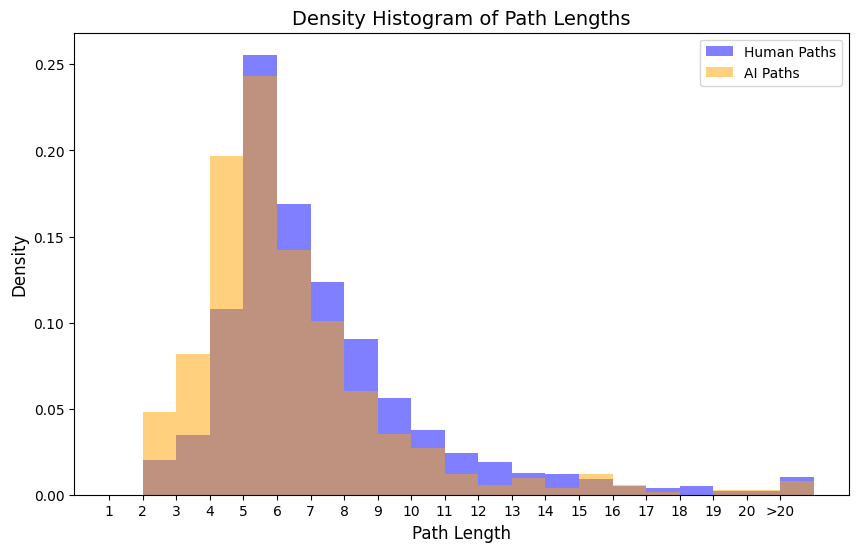

In [12]:
# the x-axis is the path length, the y-axis is the pairs

ai_path_len = [[len(path) for path in AI_paths[pair]] for pair in ori_dest]
improved_ai_paths_len = [[len(path) for path in improved_ai_paths[pair]] for pair in ori_dest]
human_path_len = [[len(path) for path in human_paths[pair]] for pair in ori_dest]
shortest_path_len = [[len(shortest_paths[pair][0])] for pair in ori_dest]

# Path Length distribution Plot
human_lengths_flat = [length for path in human_path_len for length in path]
ai_lengths_flat = [length for path in ai_path_len for length in path]

# Cap the path lengths at 20 and group all lengths >20 into a single bin
human_lengths_capped = [length if length <= 20 else 21 for length in human_lengths_flat]
ai_lengths_capped = [length if length <= 20 else 21 for length in ai_lengths_flat]

plot_histogram_of_path_lengths(human_lengths_capped, ai_lengths_capped)

In [13]:
# Path Degree Analysis
in_degrees = dict(G.in_degree())  
out_degrees = dict(G.out_degree()) 
total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in set(in_degrees) | set(out_degrees)}

AI_path_degrees = compute_path_degrees(AI_paths, out_degrees)
human_path_degrees = compute_path_degrees(human_paths, out_degrees)
shortest_path_degrees = compute_path_degrees(shortest_paths, out_degrees)

degree_filtering_length = 3
degree_first_n = 3
filtered_ai_degrees = score_filtering(AI_path_degrees, ai_path_len, degree_filtering_length, degree_first_n)
filtered_human_degrees = score_filtering(human_path_degrees, human_path_len, degree_filtering_length, degree_first_n)
filtered_shortest_degrees = score_filtering(shortest_path_degrees, shortest_path_len, degree_filtering_length, degree_first_n)

degree_means, score_means = compute_degree_and_score_means(human_path_len, ai_path_len, AI_paths, AI_path_degrees, ai_closeness_scores, human_paths, human_path_degrees, human_closeness_scores, shortest_path_degrees, optimal_closeness_scores)

plot_mean_degrees_and_closeness(degree_means, score_means)

In [14]:
before_tuning_paths = load_ai_paths('data/paths_before_tuning', ori_dest)
after_4o_tuning_paths = load_ai_paths('data/paths_after_tuning', ori_dest)
after_4o_mini_tuning_paths = load_ai_paths('data/paths_after_tuning_4o_mini', ori_dest)

plot_updated_task_path_length_comparison(before_tuning_paths, after_4o_tuning_paths, after_4o_mini_tuning_paths, ori_dest, shortest_paths, sample_fraction=0.3, fixed_height_per_pair=50, fixed_width=1400, x_jitter_offset=0.025, seed=58, y_offset=0.15)


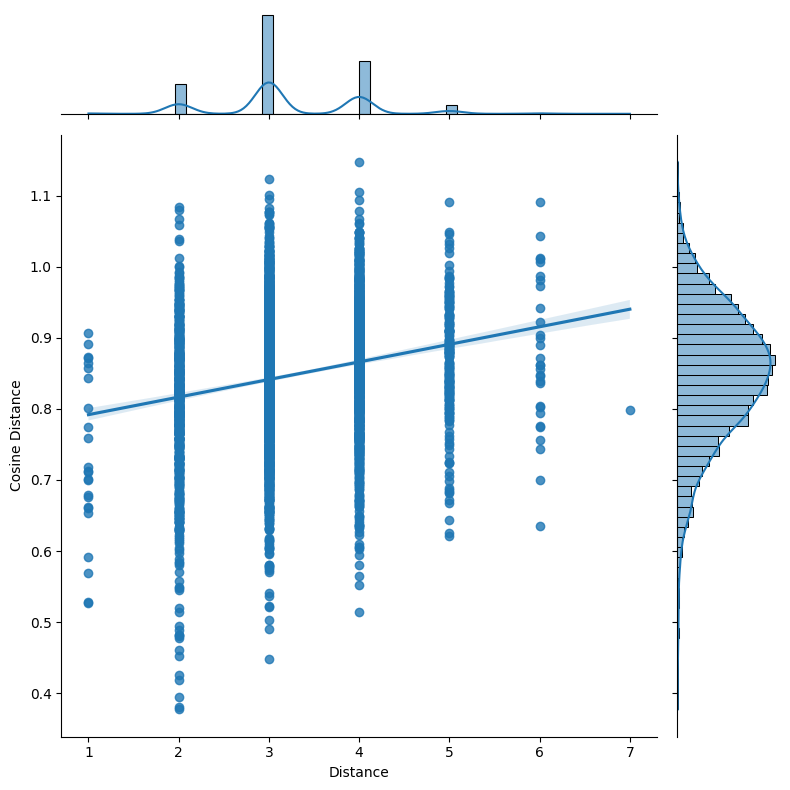

In [15]:
correlation_between_embedding_and_distance(G, sentence_embeddings, 5000)

In [16]:
baseline = load_ai_paths('data/paths', ori_dest)
manually_improved_prompt = load_ai_paths('data/paths_improved_prompt', ori_dest)
print("---------------Path 1: baseline, Path 2: manually improved prompt-------------")
paths_comparation(baseline, manually_improved_prompt, shortest_paths, ori_dest)

task_modification = load_ai_paths('data/paths_before_tuning', ori_dest)
print("-------------Path 1: baseline, Path 2: task modification-------------")
paths_comparation(baseline, task_modification, shortest_paths, ori_dest)

gpt_4o_tuning = load_ai_paths('data/paths_after_tuning', ori_dest)
print("-------------Path 1: Before tuning, Path 2: GPT-4o tuning-------------")
paths_comparation(task_modification, gpt_4o_tuning, shortest_paths, ori_dest)

gpt_4o_mini_tuning = load_ai_paths('data/paths_after_tuning_4o_mini', ori_dest)
print("-------------Path 1: Before tuning, Path 2: GPT-4o mini tuning-------------")
paths_comparation(task_modification, gpt_4o_mini_tuning, shortest_paths, ori_dest)


---------------Path 1: baseline, Path 2: manually improved prompt-------------
Failure rate for Paths 1: 0.0, Path 2: 0.0
Number of paths that are shorter for Paths 1: 33, Path 2: 69
Average for Path 1: 6.215074309978768, Path 2: 5.8055201698513805
Median path length for Path 1: 5.2, Path 2: 5.2
T test result: t_stat=2.9152835586817876, p_value=0.004077256994251107
Average difference with the shortest path for Path 1: 2.5144373673036093, Path 2: 2.104883227176221
T test result: t_stat=2.9152835586817876, p_value=0.004077256994251107
-------------Path 1: baseline, Path 2: task modification-------------
Failure rate for Paths 1: 0.0, Path 2: 0.07006369426751592
Number of paths that are shorter for Paths 1: 40, Path 2: 66
Average for Path 1: 6.113812785388128, Path 2: 5.698630136986301
Median path length for Path 1: 5.2, Path 2: 5.0
T test result: t_stat=1.9184075019203766, p_value=0.0570246309949651
Average difference with the shortest path for Path 1: 2.408333333333333, Path 2: 1.993150